In [1]:
import pandas as pd

train_choose = pd.DataFrame()
test_choose = pd.DataFrame()

%store -r train_choose
%store -r test_choose

train_choose

,270023,539001,270042,163813,519185,050025,290012,320013,160719,164701
date,,,,,,,,,,
2012-08-17,0.887,0.8620,1.0000,0.828,0.8146,1.0456,1.026,1.065,0.929,0.876
2012-08-24,0.885,0.8510,0.9990,0.823,0.8124,1.0387,1.028,1.095,0.953,0.908
2012-08-31,0.881,0.8430,0.9990,0.812,0.7940,1.0374,1.022,1.108,0.963,0.921
2012-09-07,0.889,0.8560,1.0000,0.832,0.8350,1.0600,1.024,1.139,0.989,0.942
2012-09-13,0.901,0.8640,1.0010,0.855,0.8228,1.0746,1.026,1.147,0.995,0.953
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,3.117,1.8279,4.5906,0.708,1.0662,3.3764,1.457,0.995,0.868,0.744
2021-12-28,3.030,1.8490,4.6471,0.715,1.0659,3.4207,1.467,0.997,0.869,0.745
2021-12-29,3.002,1.8486,4.6479,0.715,1.0559,3.4254,1.475,0.994,0.867,0.744


In [2]:
import numpy as np

fund_list = list(train_choose.columns)  # Get List of all ticker symbols
n_assets = len(fund_list)  # Number of assets

uniform_weights = np.ones((n_assets)) / n_assets

uniform_weights_port = pd.DataFrame([uniform_weights], columns=fund_list)

uniform_weights_port

,270023,539001,270042,163813,519185,050025,290012,320013,160719,164701
0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


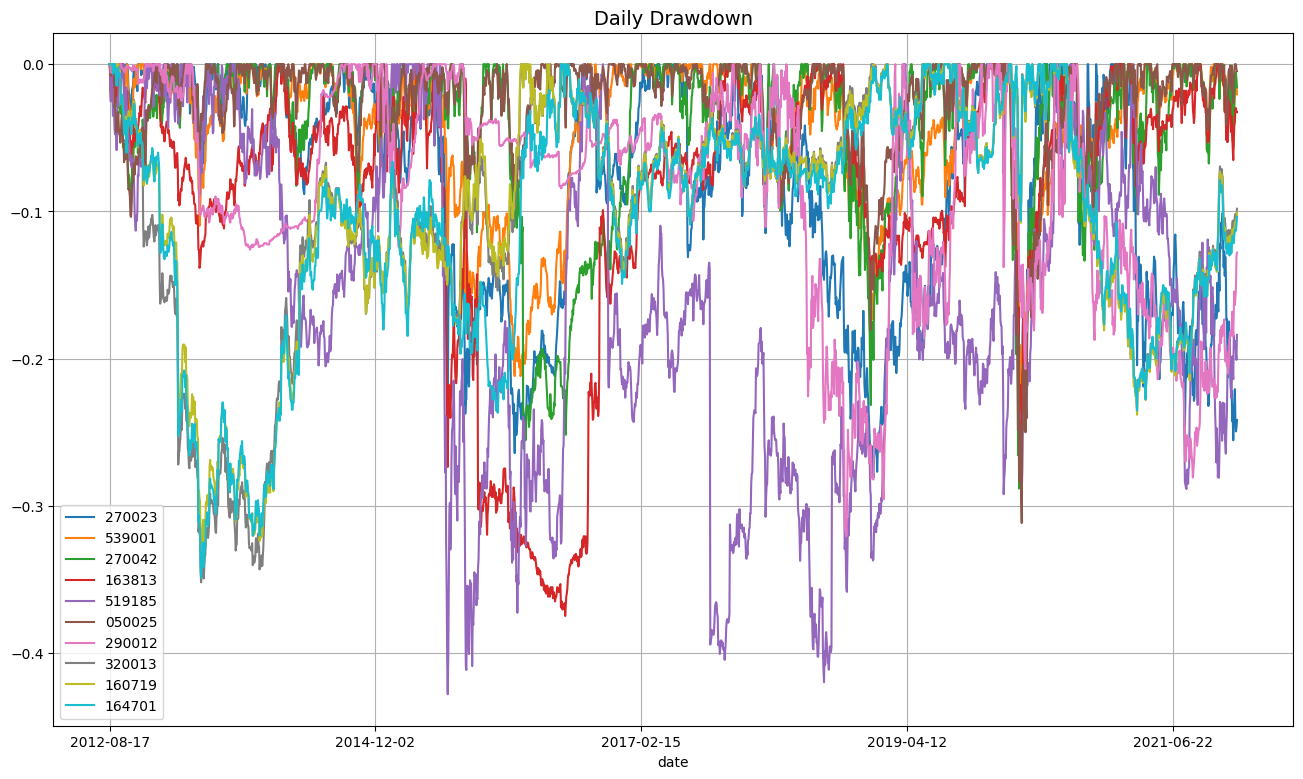

In [3]:
import matplotlib.pyplot as plt
from config import config

fund_choose = []
result_dir = ""
%store -r fund_choose
%store -r result_dir
train_choose = train_choose[fund_choose]

max_rolling = train_choose.rolling(min_periods=1, window=config.APPROX_BDAYS_PER_YEAR).max()
daily_drawdown = (train_choose / max_rolling) - 1
max_daily_drawdown = daily_drawdown.rolling(min_periods=1, window=config.APPROX_BDAYS_PER_YEAR).min()

daily_drawdown.name = "{} daily drawdown".format(fund_choose)
# daily_drawdown = pd.DataFrame(daily_drawdown)

fig, ax = plt.subplots(figsize=(16, 9))
daily_drawdown.plot(ax=ax)
ax.set_title("Daily Drawdown", fontsize=14)
plt.legend(loc="best")
plt.grid(True)
plt.show()

fig.savefig(f"{result_dir}/daily_drawdown.png")


In [4]:
# Using the average daily return to calculate portfolio return

returns = train_choose.pct_change()  # get the assets daily returns
mean_daily_returns = returns.mean().values

uw_returns = np.dot(mean_daily_returns, uniform_weights)

print("uniform weights portfolio average daily return = {:.4%}".format(uw_returns))

uniform weights portfolio average daily return = 0.0306%


In [5]:
# Annualized Return, Variance and Standard Deviation

months = (
    pd.to_datetime(train_choose.index)[-1] - pd.to_datetime(train_choose.index)[0]
) / np.timedelta64(30, "D")
months = np.floor(months)
total_return = (
    train_choose.iloc[-1].dot(uniform_weights)
    - train_choose.iloc[0].dot(uniform_weights)
) / train_choose.iloc[0].dot(uniform_weights)
uw_annual_return = ((1 + total_return) ** (12 / months)) - 1

covariance_returns = returns.cov() * 250
uw_var = np.dot(uniform_weights.T, np.dot(covariance_returns, uniform_weights))

print("uniform weights portfolio annualized return = {:.4%}".format(uw_annual_return))
print("uniform weights portfolio annualized variance = {:.1%}".format(uw_var))
print("uniform weights portfolio annualized std = {:.1%}".format(np.sqrt(uw_var)))

uniform weights portfolio annualized return = 7.6504%
uniform weights portfolio annualized variance = 1.2%
uniform weights portfolio annualized std = 10.9%


In [6]:
# Sharpe ratio

uniform_returns = returns.dot(uniform_weights)

uw_vol = uniform_returns.std() * np.sqrt(config.APPROX_BDAYS_PER_YEAR)

uw_sharpe_ratio = (uw_annual_return - config.RISK_FREE_RATE) / uw_vol

print("uniform weights portfolio sharpe ratio = {:.2f}".format(uw_sharpe_ratio))

uniform weights portfolio sharpe ratio = 0.54


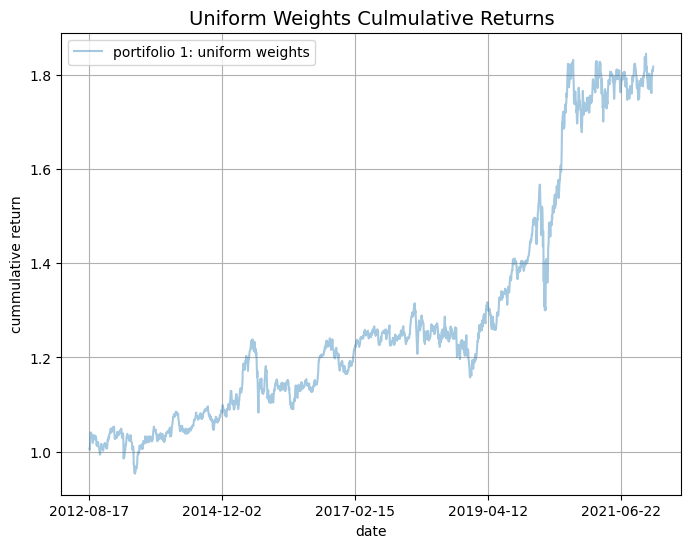

In [7]:
# Plotting the cummulative return
uniform_cum_returns = (1 + uniform_returns).cumprod()
uniform_cum_returns.name = "portifolio 1: uniform weights"

fig, ax = plt.subplots(figsize=(8, 6))
uniform_cum_returns.plot(ax=ax, alpha=0.4)

plt.legend(loc="best")
plt.grid(True)
ax.set_ylabel("cummulative return")
ax.set_title("Uniform Weights Culmulative Returns", fontsize=14)

fig.savefig(f"{result_dir}/uniform_weights_portfolio.png")

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(train_choose)
Sigma = risk_models.sample_cov(train_choose)
ef = EfficientFrontier(mu, Sigma)
# ef.add_objective(objective_functions.L2_reg, gamma=1)

raw_weights = ef.max_sharpe(risk_free_rate=config.RISK_FREE_RATE)
cleaned_weights = ef.clean_weights()
ef.portfolio_performance(verbose=True, risk_free_rate=config.RISK_FREE_RATE)

max_sharpe_portfolio = pd.DataFrame(cleaned_weights, index=[0])

%store max_sharpe_portfolio
%store uniform_weights_port

max_sharpe_portfolio

Expected annual return: 17.9%
Annual volatility: 18.1%
Sharpe Ratio: 0.88
Stored 'max_sharpe_portfolio' (DataFrame)
Stored 'uniform_weights_port' (DataFrame)


,270023,539001,270042,163813,519185,050025,290012,320013,160719,164701
0,0.22948,0.0,0.56549,0.0,0.0,0.20503,0.0,0.0,0.0,0.0


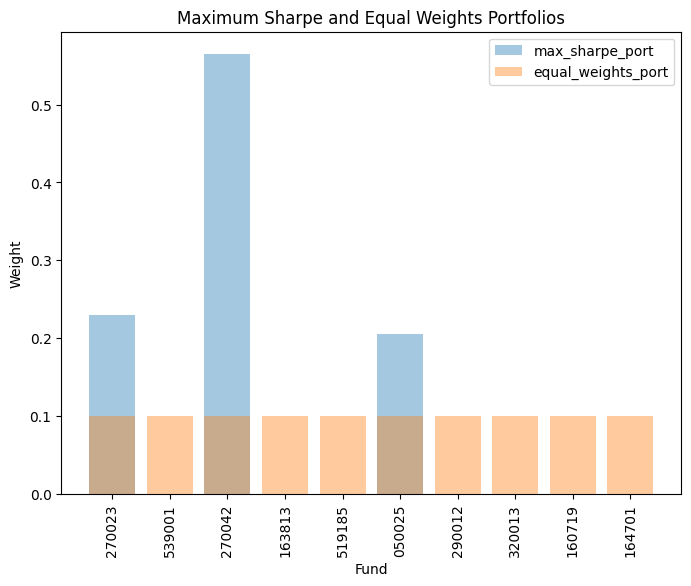

In [15]:
plt.subplots(figsize=(8, 6))
plt.title("Maximum Sharpe and Equal Weights Portfolios")
plt.bar(
    max_sharpe_portfolio.T.index,
    max_sharpe_portfolio.T[0],
    alpha=0.4,
    label="max_sharpe_port",
)
plt.bar(
    uniform_weights_port.T.index,
    uniform_weights_port.T[0],
    alpha=0.4,
    label="equal_weights_port",
)
plt.xlabel("Fund")
plt.ylabel("Weight")
plt.xticks(rotation=90)
plt.legend()
plt.show()